<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_16_CNNs_Part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the Libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# To get summaries of the models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Code Challenge: Custom Loss Function

Use the Gausian Autoencoder code from the previous section

Create your own loss function, do not use the ones available in Pytorch: 3 of them

In [2]:
# Create the Gaussian Blurs
# Number of images and image size
nGauss = 1000
imgsize = 91

x = np.linspace(-4,4,imgsize)
X,Y = np.meshgrid(x,x)

# Vary the weights smoothly: Every Gaussian has its own unique parameter
widths = np.linspace(2,20,nGauss)

# Initialize tensots containing images and labels
images = torch.zeros(nGauss,1 ,imgsize, imgsize)

# Create the images
for i in range(nGauss):

    # Create Gaussians with random centers
    ro = 1.5*np.random.randn(2) # ro: random offset
    G  = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i])

    # Add Noise
    G = G + np.random.randn(imgsize, imgsize)/5

    # Add Occlusion randomly
    # Any pixel between 2 and 28
    i1 = np.random.choice(np.arange(2,28))
    # Any pixel between 2 and 6
    i2 = np.random.choice(np.arange(2,6))

    # Add the occlusion bar
    if np.random.randn() > 0:
        G[i1:i1+i2,:] = 1
    else:
        G[:,i1:i1+i2] = 1

    # Add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1, imgsize, imgsize)

print(images.shape)

torch.Size([1000, 1, 91, 91])


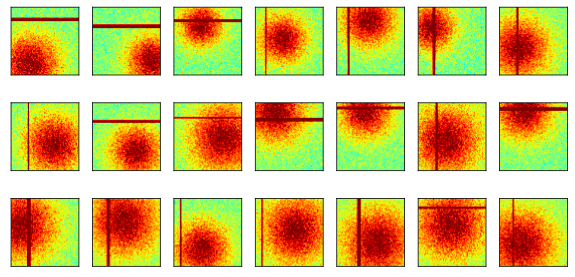

In [3]:
# Show some random images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic,:,:])
    ax.imshow(G, vmin=-1,vmax=1, cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Custom Loss Functions

In [4]:
class myL1Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yHat, y):
        l = torch.mean(torch.abs(yHat - y))
        return l

In [5]:
class MyL2AveLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yHat, y):
        # MSE + Average
        l = torch.mean(torch.abs(yHat - y)) + torch.abs(torch.mean(yHat))

        return l

In [24]:
class MyCorrLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yHat, y):
        mean_yHat = torch.mean(yHat)
        mean_y = torch.mean(y)
    
        numerator = torch.sum((yHat - mean_yHat)*(y - mean_y))
        # torch.numel() returns the total number of elements in a tensor
        denominator = (torch.numel(y) - 1)*torch.std(yHat)*torch.std(y)
        # We want the correlation to be large, thus negative sign
        return -numerator/denominator

In [7]:
# Create a class for the model
def makeTheNet():

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoding Layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
                )
            
            # Decoding Layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2)
                )
            
        def forward(self,x):
            return self.dec(self.enc(x))

    # Create model Instance
    net = GaussNet()

    # Define the loss function
    # lossfun = nn.MSELoss()
    lossfun = myL1Loss()
    # lossfun = MyL2AveLoss
    # lossfun = MyCorrLoss

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [8]:
# Create a function to train the model
def function2trainTheModel():

    # Number of epochs: experimental time
    numepochs = 1000

    # create new model instance
    net, lossfun, optimizer = makeTheNet()

    losses = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Pick a set of images at random
        pics2use = np.random.choice(nGauss,size=32,replace=False)
        X = images[pics2use,:,:,:]


        # Forward Pass and Loss
        yHat = net(X)
        # Loss is difference of the whole data matrix
        loss = lossfun(yHat,X)
        losses.append(loss.item())

        # BackProp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # End of epochs loop

    # The final output
    return losses, net

In [9]:
losses, net = function2trainTheModel()

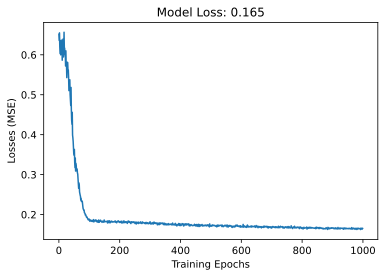

In [10]:
plt.plot(losses, label="Train")
plt.xlabel("Training Epochs")
plt.ylabel("Losses (MSE)")
plt.title(f"Model Loss: {losses[-1]:.3f}")
plt.show()

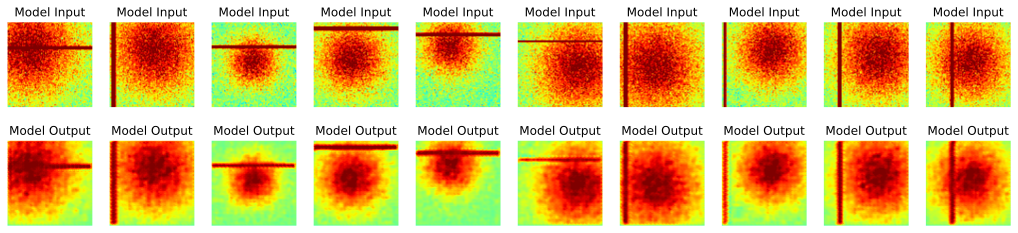

In [11]:
# Pick some random images and visualize them
pics2use = np.random.choice(nGauss, size=32,replace=False)

X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):

    G = torch.squeeze(X[i,0,:,:]).detach()
    O = torch.squeeze(yHat[i,0,:,:]).detach()

    axs[0,i].imshow(G,vmin=-1, vmax=1,cmap="jet")
    axs[0,i].axis("off")
    axs[0,i].set_title("Input ($\mu$=%.2f)"%torch.mean(G).item(),fontsize=9)

    axs[1,i].imshow(O,vmin=-1, vmax=1,cmap="jet")
    axs[1,i].axis("off")
    axs[1,i].set_title("Output ($\mu$=%.2f)"%torch.mean(O).item(),fontsize=9)

plt.show()

In [18]:
# Create a class for the model: L2Ave loss
def makeTheNet():

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoding Layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
                )
            
            # Decoding Layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2)
                )
            
        def forward(self,x):
            return self.dec(self.enc(x))

    # Create model Instance
    net = GaussNet()

    # Define the loss function
    # lossfun = nn.MSELoss()
    # lossfun = myL1Loss()
    lossfun = MyL2AveLoss()
    # lossfun = MyCorrLoss

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [19]:
losses, net = function2trainTheModel()

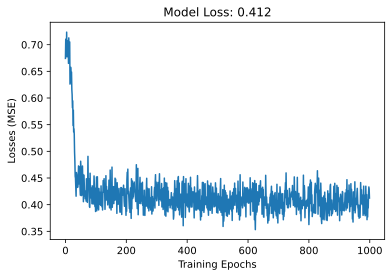

In [20]:
plt.plot(losses, label="Train")
plt.xlabel("Training Epochs")
plt.ylabel("Losses (MSE)")
plt.title(f"Model Loss: {losses[-1]:.3f}")
plt.show()

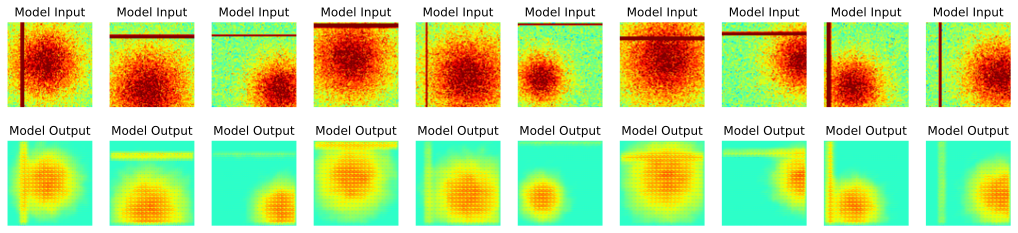

In [21]:
# Pick some random images and visualize them
pics2use = np.random.choice(nGauss, size=32,replace=False)

X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):

    G = torch.squeeze(X[i,0,:,:]).detach()
    O = torch.squeeze(yHat[i,0,:,:]).detach()

    axs[0,i].imshow(G,vmin=-1, vmax=1,cmap="jet")
    axs[0,i].axis("off")
    axs[0,i].set_title("Input ($\mu$=%.2f)"%torch.mean(G).item(),fontsize=9)

    axs[1,i].imshow(O,vmin=-1, vmax=1,cmap="jet")
    axs[1,i].axis("off")
    axs[1,i].set_title("Output ($\mu$=%.2f)"%torch.mean(O).item(),fontsize=9)

plt.show()

In [25]:
# Create a class for the model: Correlatio 
def makeTheNet():

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoding Layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
                )
            
            # Decoding Layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2)
                )
            
        def forward(self,x):
            return self.dec(self.enc(x))

    # Create model Instance
    net = GaussNet()

    # Define the loss function
    # lossfun = nn.MSELoss()
    # lossfun = myL1Loss()
    # lossfun = MyL2AveLoss()
    lossfun = MyCorrLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [26]:
losses, net = function2trainTheModel()

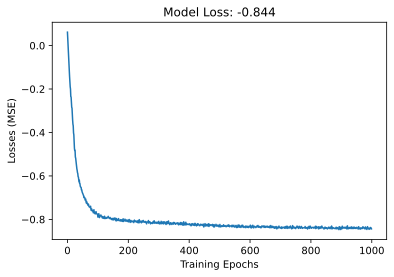

In [27]:
plt.plot(losses, label="Train")
plt.xlabel("Training Epochs")
plt.ylabel("Losses (MSE)")
plt.title(f"Model Loss: {losses[-1]:.3f}")
plt.show()

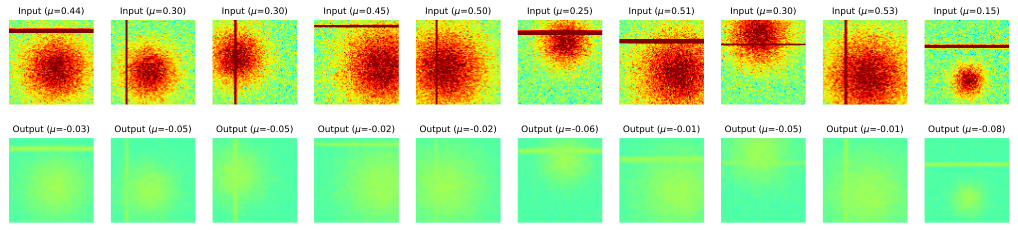

In [28]:
# Pick some random images and visualize them
pics2use = np.random.choice(nGauss, size=32,replace=False)

X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):

    G = torch.squeeze(X[i,0,:,:]).detach()
    O = torch.squeeze(yHat[i,0,:,:]).detach()

    axs[0,i].imshow(G,vmin=-1, vmax=1,cmap="jet")
    axs[0,i].axis("off")
    axs[0,i].set_title("Input ($\mu$=%.2f)"%torch.mean(G).item(),fontsize=9)

    axs[1,i].imshow(O,vmin=-1, vmax=1,cmap="jet")
    axs[1,i].axis("off")
    axs[1,i].set_title("Output ($\mu$=%.2f)"%torch.mean(O).item(),fontsize=9)

plt.show()